In [1]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns
from wishpy.dataworker import DataWorker
dw = DataWorker(google_secret='../../../wishpy/client_secret.json')
import math

# from scipy import stats
from scipy.stats import chi2, chi2_contingency
import statsmodels.stats.api as sms

import ttd_experiment as ttd

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/wishpy/dataworker.py:83: UserWarning: [Errno 2] No such file or directory: '../../../wishpy/client_secret.json'
  warnings.warn(str(e))


## Prepare the data

In [5]:
df = dw.td_query('''
'''
,job_id=737497424
,engine='presto'
                )
df.head()

You can look at job id 737497424


,dimension,age_bucket,gender,country_code,domain,avg_value_bucket,has_ever_refund,month_0_user,month_1_user,month_2_user,...,month_4_user,month_5_user,month_6_user,month_7_user,month_8_user,month_9_user,month_10_user,month_11_user,month_12_user,month_13_plus_user
0,overall_month_country,all,999.0,MM,all,all,all,1797,203,120,...,65,40,36,23,5,4,0,0,0,0
1,overall_month_country,all,999.0,PF,all,all,all,573,97,69,...,31,27,20,9,10,1,0,1,0,0
2,overall_month_country,all,999.0,PA,all,all,all,9517,1300,1023,...,479,358,224,112,68,39,6,3,0,0
3,overall_month_country,all,999.0,IM,all,all,all,3110,643,471,...,264,238,162,93,54,20,7,2,0,0
4,overall_month_country,all,999.0,fr,all,all,all,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56547 entries, 0 to 56546
Data columns (total 21 columns):
dimension             56547 non-null object
age_bucket            56546 non-null object
gender                56546 non-null float64
country_code          56546 non-null object
domain                56546 non-null object
avg_value_bucket      56546 non-null object
has_ever_refund       56547 non-null object
month_0_user          56547 non-null int64
month_1_user          56547 non-null int64
month_2_user          56547 non-null int64
month_3_user          56547 non-null int64
month_4_user          56547 non-null int64
month_5_user          56547 non-null int64
month_6_user          56547 non-null int64
month_7_user          56547 non-null int64
month_8_user          56547 non-null int64
month_9_user          56547 non-null int64
month_10_user         56547 non-null int64
month_11_user         56547 non-null int64
month_12_user         56547 non-null int64
month_13_plus_user    5

In [27]:
months = ['month_0_user','month_1_user','month_2_user','month_3_user','month_4_user','month_5_user','month_6_user','month_7_user','month_8_user','month_9_user','month_10_user',
         'month_11_user','month_12_user','month_13_plus_user']
months_p = ['month_0_user_p','month_1_user_p','month_2_user_p','month_3_user_p','month_4_user_p','month_5_user_p','month_6_user_p','month_7_user_p','month_8_user_p','month_9_user_p','month_10_user_p',
         'month_11_user_p','month_12_user_p','month_13_plus_user_p']

# for month, month_p in zip(months,months_p):
#     df[month_p] = df.apply(lambda row: round(100*row[month]/(row['month_0_user']+0.001),2),axis=1)
# df.head(10)

In [28]:
for month, month_p in zip(months,months_p):
    df[month_p] = df.apply(lambda row: round(100*row[month]/(row['month_0_user']+0.001),2),axis=1)
df.head(10)

,dimension,age_bucket,gender,country_code,domain,avg_value_bucket,has_ever_refund,month_0_user,month_1_user,month_2_user,...,month_4_user_p,month_5_user_p,month_6_user_p,month_7_user_p,month_8_user_p,month_9_user_p,month_10_user_p,month_11_user_p,month_12_user_p,month_13_plus_user_p
0,overall_month_country,all,999.0,MM,all,all,all,1797,203,120,...,3.62,2.23,2.00,1.28,0.28,0.22,0.00,0.00,0.00,0.0
1,overall_month_country,all,999.0,PF,all,all,all,573,97,69,...,5.41,4.71,3.49,1.57,1.75,0.17,0.00,0.17,0.00,0.0
2,overall_month_country,all,999.0,PA,all,all,all,9517,1300,1023,...,5.03,3.76,2.35,1.18,0.71,0.41,0.06,0.03,0.00,0.0
3,overall_month_country,all,999.0,IM,all,all,all,3110,643,471,...,8.49,7.65,5.21,2.99,1.74,0.64,0.23,0.06,0.00,0.0
4,overall_month_country,all,999.0,fr,all,all,all,1,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
5,overall_month_country,all,999.0,ST,all,all,all,7,1,1,...,14.28,0.00,14.28,0.00,0.00,0.00,0.00,0.00,0.00,0.0
6,overall_month_country,all,999.0,FI,all,all,all,118409,18569,14052,...,7.24,5.72,4.44,3.42,2.33,1.55,0.88,0.37,0.02,0.0
7,overall_month_country,all,999.0,CA,all,all,all,1218909,211998,155509,...,7.78,6.11,4.65,3.43,2.36,1.54,0.95,0.45,0.01,0.0
8,overall_month_country,all,999.0,BJ,all,all,all,44,4,3,...,2.27,0.00,0.00,2.27,0.00,2.27,0.00,0.00,0.00,0.0
9,overall_month_country,all,999.0,SX,all,all,all,112,29,16,...,8.04,5.36,5.36,4.46,4.46,0.89,0.00,0.00,0.00,0.0


## Plot of retention

### overall retention plot

In [66]:
df_overall_month = df.loc[df.dimension=='overall_month',].melt(id_vars=['dimension','age_bucket','gender','country_code','domain','avg_value_bucket','has_ever_refund'], 
                                                               value_vars=months_p,
                                                               var_name='month_bucket', value_name='month_value').sort_values(by='month_value',ascending=False).set_index('month_bucket')
df_overall_month 

,dimension,age_bucket,gender,country_code,domain,avg_value_bucket,has_ever_refund,month_value
month_bucket,,,,,,,,
month_0_user_p,overall_month,all,999.0,all,all,all,all,100.00
month_1_user_p,overall_month,all,999.0,all,all,all,all,15.69
month_2_user_p,overall_month,all,999.0,all,all,all,all,11.56
month_3_user_p,overall_month,all,999.0,all,all,all,all,8.83
month_4_user_p,overall_month,all,999.0,all,all,all,all,6.70
month_5_user_p,overall_month,all,999.0,all,all,all,all,5.14
month_6_user_p,overall_month,all,999.0,all,all,all,all,3.84
month_7_user_p,overall_month,all,999.0,all,all,all,all,2.78
month_8_user_p,overall_month,all,999.0,all,all,all,all,1.88


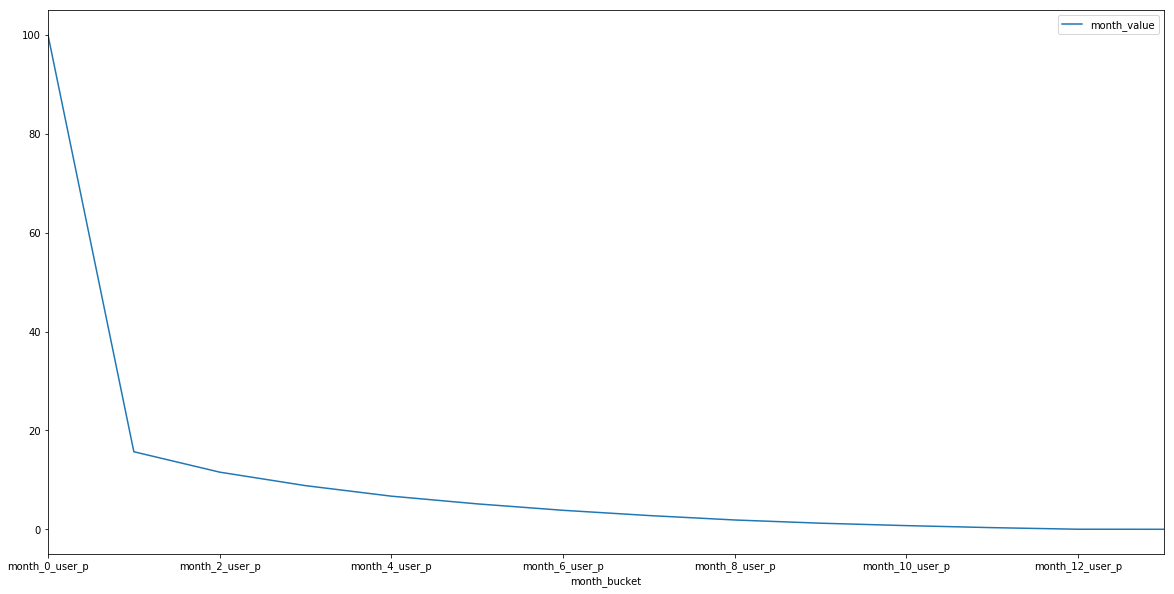

In [26]:
df_overall_month.plot(y='Volume',figsize=(20, 10))

### overall_month_age

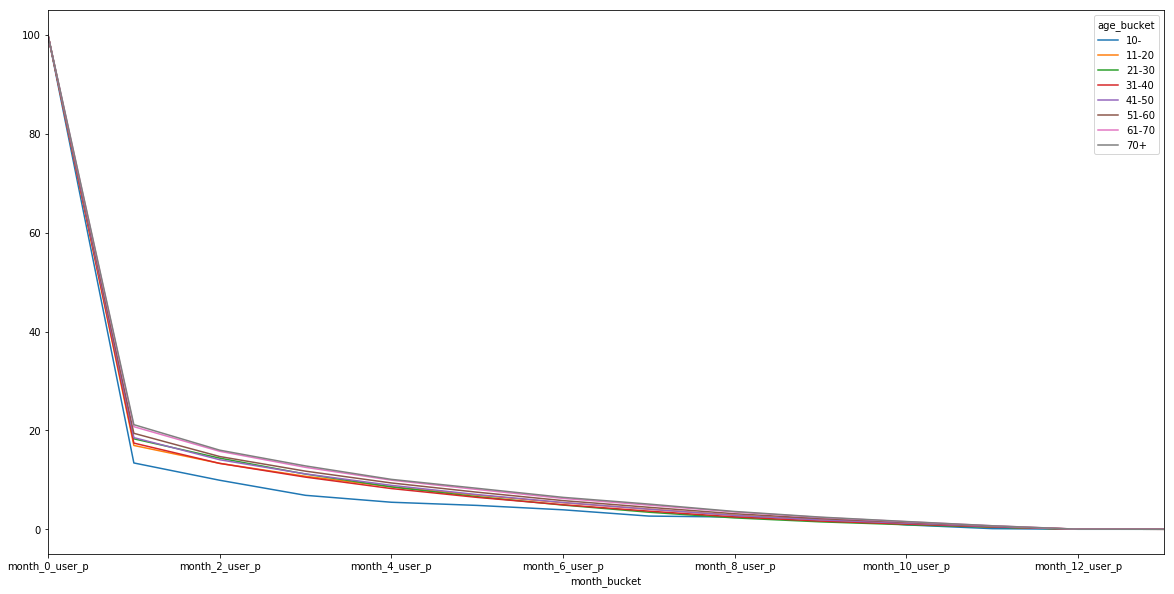

In [48]:
df_overall_month = df.loc[df.dimension=='overall_month_age',].melt(id_vars=['dimension','age_bucket','gender','country_code','domain','avg_value_bucket','has_ever_refund'], 
                                                               value_vars=months_p,
                                                               var_name='month_bucket', value_name='month_value').sort_values(by='month_value',ascending=False).set_index('month_bucket')
df_overall_month2 = df_overall_month.pivot_table(columns='age_bucket', values='month_value', index='month_bucket').sort_values(by='11-20',ascending=False)
df_overall_month2.plot(figsize=(20, 10))

### overall_month_gender

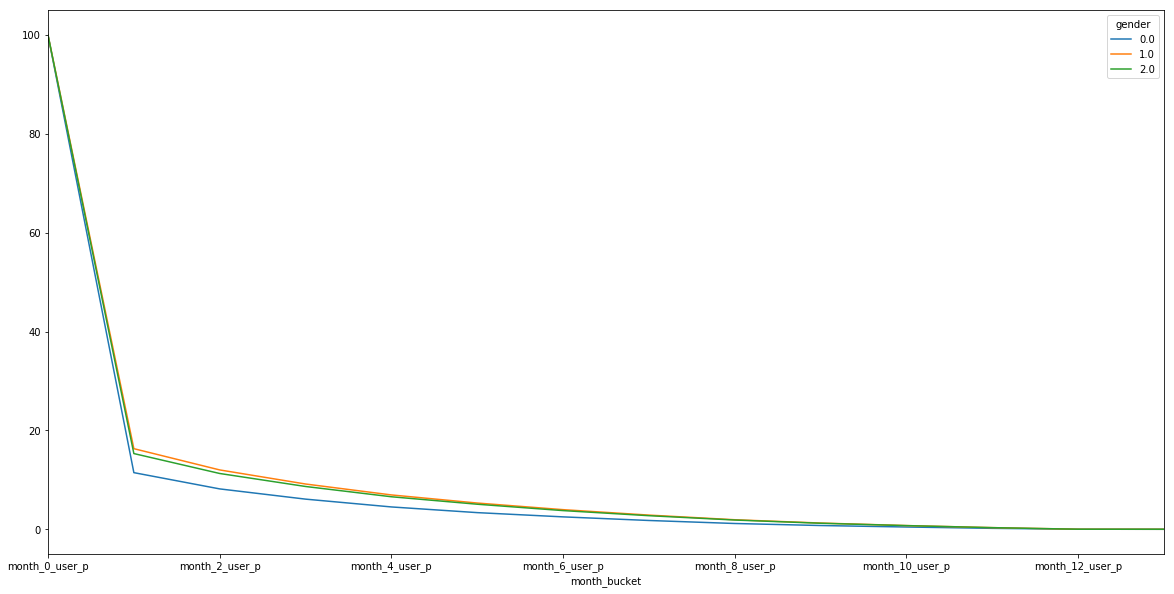

In [62]:
df_overall_gender = df.loc[df.dimension=='overall_month_gender',].melt(id_vars=['dimension','age_bucket','gender','country_code','domain','avg_value_bucket','has_ever_refund'], 
                                                               value_vars=months_p,
                                                               var_name='month_bucket', value_name='month_value').sort_values(by='month_value',ascending=False).set_index('month_bucket')
x = list(set(df.gender))
df_overall_gender2 = df_overall_gender.pivot_table(columns='gender', values='month_value', index='month_bucket').sort_values(by=x[1],ascending=False)
df_overall_gender2.plot(figsize=(20, 10))
# df_overall_gender2

### has ever refund

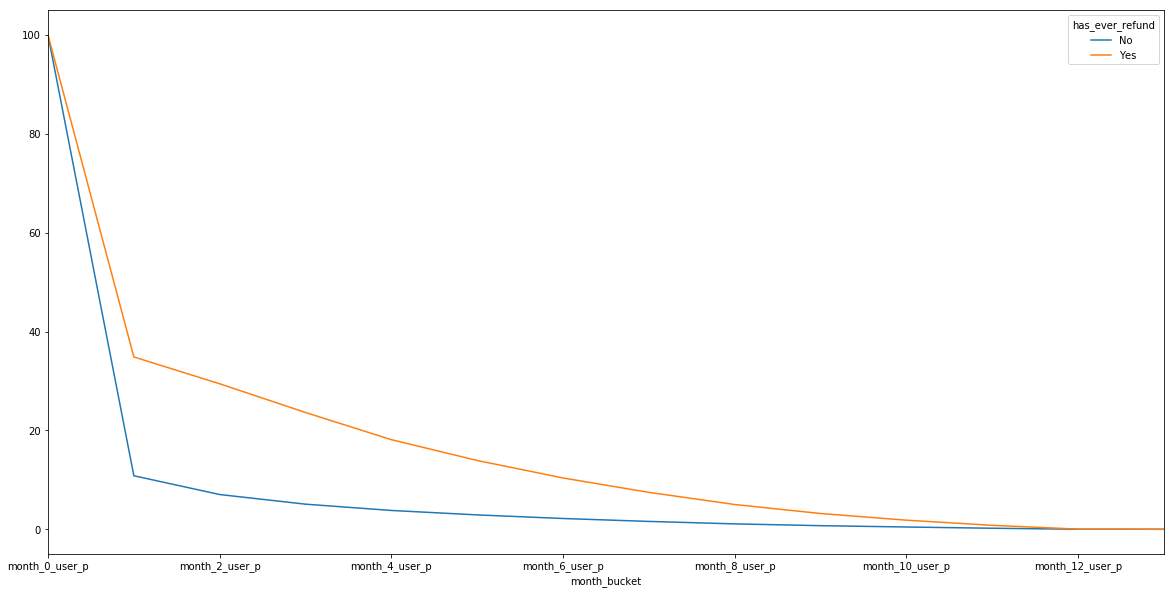

In [64]:
df_overall_has_ever_refund = df.loc[df.dimension=='overall_month_has_refund',].melt(id_vars=['dimension','age_bucket','gender','country_code','domain','avg_value_bucket','has_ever_refund'], 
                                                               value_vars=months_p,
                                                               var_name='month_bucket', value_name='month_value').sort_values(by='month_value',ascending=False).set_index('month_bucket')
x = list(set(df.has_ever_refund))
df_overall_has_ever_refund2 = df_overall_has_ever_refund.pivot_table(columns='has_ever_refund', values='month_value', index='month_bucket').sort_values(by=x[1],ascending=False)
df_overall_has_ever_refund2.plot(figsize=(20, 10))
# df_overall_gender2

### avg_value_bucket


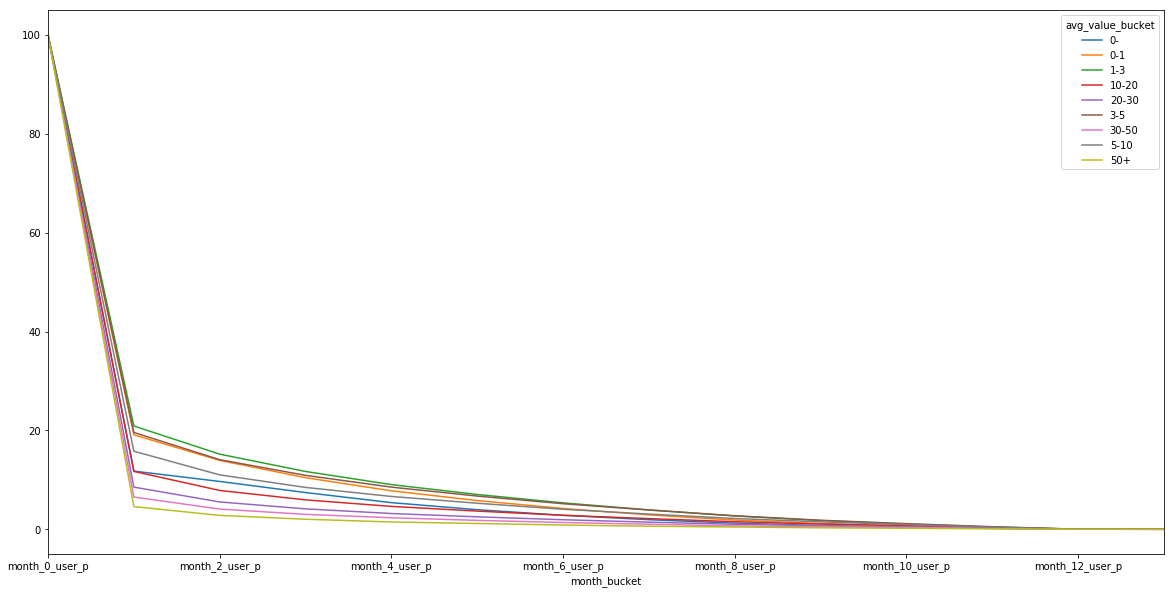

In [65]:
df_overall_avg_value = df.loc[df.dimension=='overall_month_value',].melt(id_vars=['dimension','age_bucket','gender','country_code','domain','avg_value_bucket','has_ever_refund'], 
                                                               value_vars=months_p,
                                                               var_name='month_bucket', value_name='month_value').sort_values(by='month_value',ascending=False).set_index('month_bucket')
x = list(set(df.avg_value_bucket))
df_overall_avg_value2 = df_overall_avg_value.pivot_table(columns='avg_value_bucket', values='month_value', index='month_bucket').sort_values(by=x[1],ascending=False)
df_overall_avg_value2.plot(figsize=(20, 10))